#Group 23:
- Albert Adiputra (7907746)
  - contribution123
- Jason Thajeb
  - contribution123
- Aung Kyaw Saw (8215443)
  - contribution123
- Daniel P (8221522)
  - contribution123
- Soe Min Oo (8221881)
  - contribution123

---

#Facial Expression Recognition
- This project is to develop a machine learning model to identify
and categorize emotional expressions depicted on a human face.
- The following website is a
good source for you to understand this topic. Students can use the dataset provided on the
website and shall systematically investigate how good the developed model works.
  - https://paperswithcode.com/task/facial-expression-recognition
- Implemented tools
  - CNN, VGG, ResNet, Transfer Learning
- Implementation
  - Option 1: students only need to evaluate at least three baselines, which may be from the other
existing work/solutions;
  - Option 2: students can choose one from the existing work/solutions, and implement another one
themselves to beat the selected one

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

#Machine Learning
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

#Base CNN Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

#Resnet Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

Load and Preprocess the FER2013 Dataset

In [ ]:
# Load the dataset
drive.mount('/content/drive/')
data = pd.read_csv('/content/drive/MyDrive/EmotionRecognition/fer2013.csv')
data_train = pd.read_csv('/content/drive/MyDrive/EmotionRecognition/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/EmotionRecognition/test.csv')

# Combine the train and test datasets if needed
data_combined = pd.concat([data_train, data_test])

# Filter the dataset to include only the 7 specified labels
data_combined = data_combined[data_combined['emotion'] < 7]

# Preprocess the pixel data
data_combined['pixels'] = data_combined['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48, 1))

# Normalize the pixel values
data_combined['pixels'] = data_combined['pixels'] / 255.0

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data_combined, test_size=0.2, random_state=42)

# Prepare the data for the model
def prepare_data(data):
    images = np.stack(data['pixels'].values)
    labels = to_categorical(data['emotion'], num_classes=7)
    return images, labels

x_train, y_train = prepare_data(train_data)
x_test, y_test = prepare_data(test_data)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# No augmentation for testing, just rescaling
test_datagen = ImageDataGenerator()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Read Training Dataset and Testing Dataset

Training Images:


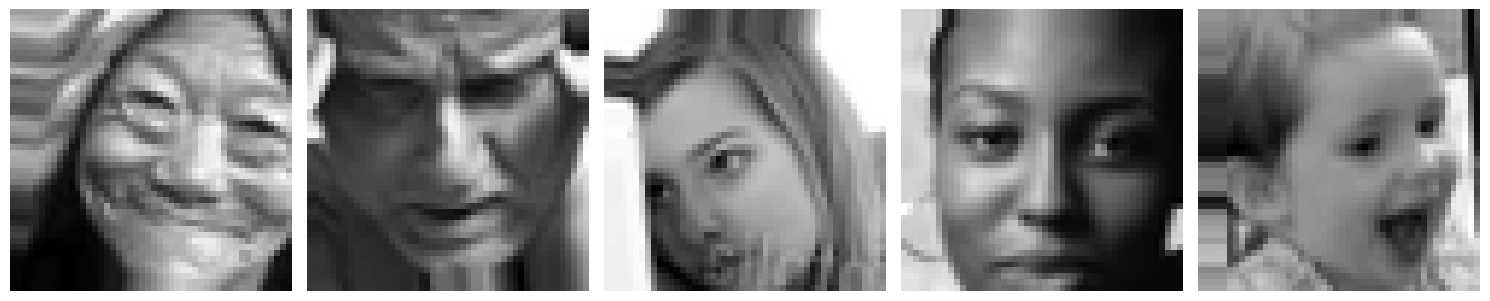

Testing Images:


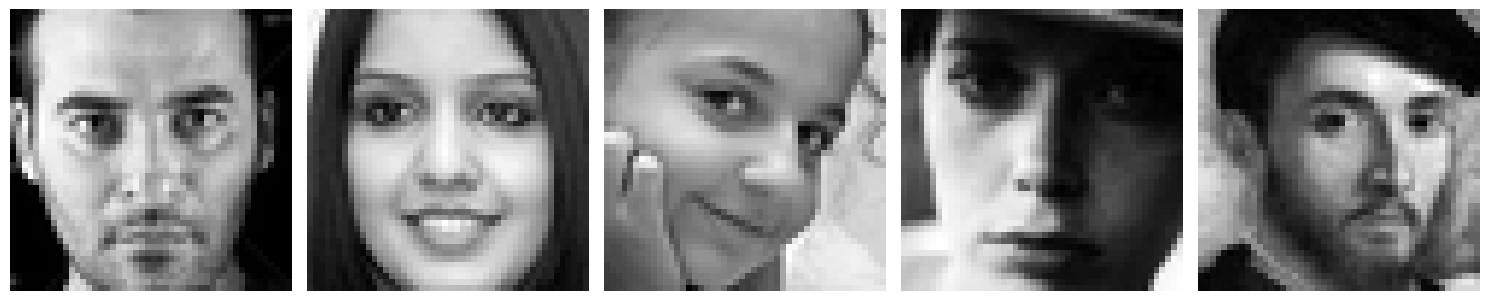

In [ ]:
# Create data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=5)
test_generator = test_datagen.flow(x_test, y_test, batch_size=5)

# Function to plot images from a data generator
def plot_images_from_generator(generator, num_images=5):
    # Retrieve a batch of images and labels
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    axes = axes.flatten()

    for img, ax in zip(images, axes):
        # Display image
        ax.imshow(img.squeeze(), cmap='gray')  # Use grayscale colormap
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot some images from the train generator
print("Training Images:")
plot_images_from_generator(train_generator)

# Plot some images from the test generator
print("Testing Images:")
plot_images_from_generator(test_generator)

Define and Train Base Model,VGG16 Model and ResNet50 Model

# Base CNN Model

In [ ]:
# Base CNN Source: https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-3-fer2013-c38f2e052280
# Define the Base CNN model
def create_base_cnn():
  # Initialize variables
  num_features = 64
  num_labels = 7
  batch_size = 64
  epochs = 100
  width, height = 48, 48

  model = Sequential()

  # Add convolutional layers for feeature extraction with input shape of (48x48x1), 1 represents greyscale image value
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization()) #Normalize output of convolutional layer to improve training speed and increase stability
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) #Reduce height and weight of feature map by taking max value of 2x2 window
  model.add(Dropout(0.5)) # Drop 50% neurons randomly to prevent overfitting

  # 2x number of features, enhance model capacity to learn complex features
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  # 4x num of features
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  # 8x num of features
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  # Convert 3D vector map to 1D for fully connected layers
  model.add(Flatten())

  # Fully connected layers with decreasing number of neurons with application of ReLu activation
  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4)) # Prevent overfitting
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  # Output layer, num_labels (7), number of labels model can predict with activation of softmax to output probability distribution over class for multi-class classification
  model.add(Dense(num_labels, activation='softmax'))

  return model

model_base_cnn = create_base_cnn()
model_base_cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
#view base model summary
model_base_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

# VGG16 Model

In [ ]:
# Define the VGG16 Model
def create_vgg16():
    # Define the input layer with grayscale image shape
    input_layer = Input(shape=(48, 48, 1))

    # Instantiate the VGG16 model with no weights to avoid loading imagenet weights for the incompatible input layer
    base_model = VGG16(weights=None, include_top=False, input_tensor=input_layer)

    # Reinitialize the first convolutional layer to handle grayscale inputs
    base_model.layers[1] = Conv2D(64, (3, 3), activation='relu', padding='same',
                                  name='block1_conv1', kernel_initializer=RandomNormal(),
                                  bias_initializer=RandomNormal())

    # Use modified base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze rest of the layers to retain pre-trained features
    for layer in base_model.layers[2:]:  # Skipping the first layer that we reinitialized
        layer.trainable = False

    return model

model_vgg16 = create_vgg16()
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#view the model vgg16 model summary
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

# Resnet Model

In [ ]:
# Define the Resnet model
def create_resnet50():
    # Define the input layer with grayscale image shape
    input_layer = Input(shape=(48, 48, 1))

    # Instantiate the ResNet50 model without weights to avoid loading imagenet weights for the incompatible input layer
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_layer)

    # Reinitialize the first convolutional layer to handle grayscale inputs
    base_model.layers[2] = Conv2D(64, (7, 7), strides=(2, 2), padding='same',
                                  name='conv1_conv', kernel_initializer=RandomNormal(),
                                  bias_initializer=RandomNormal())

    # Continue with the rest of the ResNet50 model as usual
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the rest of the layers to retain pre-trained features
    for layer in base_model.layers[3:]:  # Skipping the first two layers that were reinitialized and input
        layer.trainable = False

    return model

model_resnet50 = create_resnet50()
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#view the model ResNet50 model summary
model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 1)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

# Training and Testing

In [ ]:
batch_size = 32
epochs = 80

CNNMODELPATH = './models/CNNmodel.keras'
VGGMODELPATH = './models/VGGmodel.keras'
RESMODELPATH = './models/RESmodel.keras'

cnncheckpointer = ModelCheckpoint(CNNMODELPATH, monitor='val_loss', verbose=1, save_best_only=True)
vggcheckpointer = ModelCheckpoint(VGGMODELPATH, monitor='val_loss', verbose=1, save_best_only=True)
rescheckpointer = ModelCheckpoint(RESMODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-5)

Train CNN based model

In [ ]:
# Train Base CNN model
history_base_cnn = model_base_cnn.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=test_datagen.flow(x_test, y_test, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_test) // batch_size,
    epochs=epochs,
    callbacks=[cnncheckpointer, reduce_lr]
)

Epoch 1/80
717/717 [==============================] - ETA: 0s - loss: 2.0010 - accuracy: 0.2155
Epoch 1: val_loss improved from inf to 1.81609, saving model to ./models/CNNmodel.keras
717/717 [==============================] - 134s 182ms/step - loss: 2.0010 - accuracy: 0.2155 - val_loss: 1.8161 - val_accuracy: 0.2561 - lr: 0.0010
Epoch 2/80
717/717 [==============================] - ETA: 0s - loss: 1.8356 - accuracy: 0.2472
Epoch 2: val_loss improved from 1.81609 to 1.80923, saving model to ./models/CNNmodel.keras
717/717 [==============================] - 128s 178ms/step - loss: 1.8356 - accuracy: 0.2472 - val_loss: 1.8092 - val_accuracy: 0.2556 - lr: 0.0010
Epoch 3/80
717/717 [==============================] - ETA: 0s - loss: 1.8215 - accuracy: 0.2484
Epoch 3: val_loss did not improve from 1.80923
717/717 [==============================] - 127s 177ms/step - loss: 1.8215 - accuracy: 0.2484 - val_loss: 1.8173 - val_accuracy: 0.2563 - lr: 0.0010
Epoch 4/80
717/717 [=====================

Train VGG16 model

In [ ]:
# Train VGG16 model
history_vgg16 = model_vgg16.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=test_datagen.flow(x_test, y_test, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_test) // batch_size,
    epochs=epochs,
    callbacks=[vggcheckpointer, reduce_lr]
)

Epoch 1/80
717/717 [==============================] - ETA: 0s - loss: 1.8187 - accuracy: 0.2496
Epoch 1: val_loss improved from inf to 1.79265, saving model to ./models/VGGmodel.keras
717/717 [==============================] - 170s 236ms/step - loss: 1.8187 - accuracy: 0.2496 - val_loss: 1.7927 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 2/80
717/717 [==============================] - ETA: 0s - loss: 1.7932 - accuracy: 0.2507
Epoch 2: val_loss improved from 1.79265 to 1.77701, saving model to ./models/VGGmodel.keras
717/717 [==============================] - 170s 238ms/step - loss: 1.7932 - accuracy: 0.2507 - val_loss: 1.7770 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 3/80
717/717 [==============================] - ETA: 0s - loss: 1.7836 - accuracy: 0.2535
Epoch 3: val_loss improved from 1.77701 to 1.77188, saving model to ./models/VGGmodel.keras
717/717 [==============================] - 170s 237ms/step - loss: 1.7836 - accuracy: 0.2535 - val_loss: 1.7719 - val_accuracy: 0.2615 - lr: 0.0

Train ResNet50 model

In [ ]:
# # Train ResNet50 model
history_resnet50 = model_resnet50.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=test_datagen.flow(x_test, y_test, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_test) // batch_size,
    epochs=epochs,
    callbacks=[rescheckpointer, reduce_lr]
)

Epoch 1/80
717/717 [==============================] - ETA: 0s - loss: 1.8180 - accuracy: 0.2497
Epoch 1: val_loss improved from inf to 1.79642, saving model to ./models/RESmodel.keras
717/717 [==============================] - 151s 206ms/step - loss: 1.8180 - accuracy: 0.2497 - val_loss: 1.7964 - val_accuracy: 0.2565 - lr: 0.0010
Epoch 2/80
717/717 [==============================] - ETA: 0s - loss: 1.7979 - accuracy: 0.2491
Epoch 2: val_loss improved from 1.79642 to 1.78039, saving model to ./models/RESmodel.keras
717/717 [==============================] - 148s 206ms/step - loss: 1.7979 - accuracy: 0.2491 - val_loss: 1.7804 - val_accuracy: 0.2558 - lr: 0.0010
Epoch 3/80
717/717 [==============================] - ETA: 0s - loss: 1.7885 - accuracy: 0.2534
Epoch 3: val_loss improved from 1.78039 to 1.76805, saving model to ./models/RESmodel.keras
717/717 [==============================] - 147s 205ms/step - loss: 1.7885 - accuracy: 0.2534 - val_loss: 1.7680 - val_accuracy: 0.2648 - lr: 0.0

Plot Accuracy and Loss of Each Model

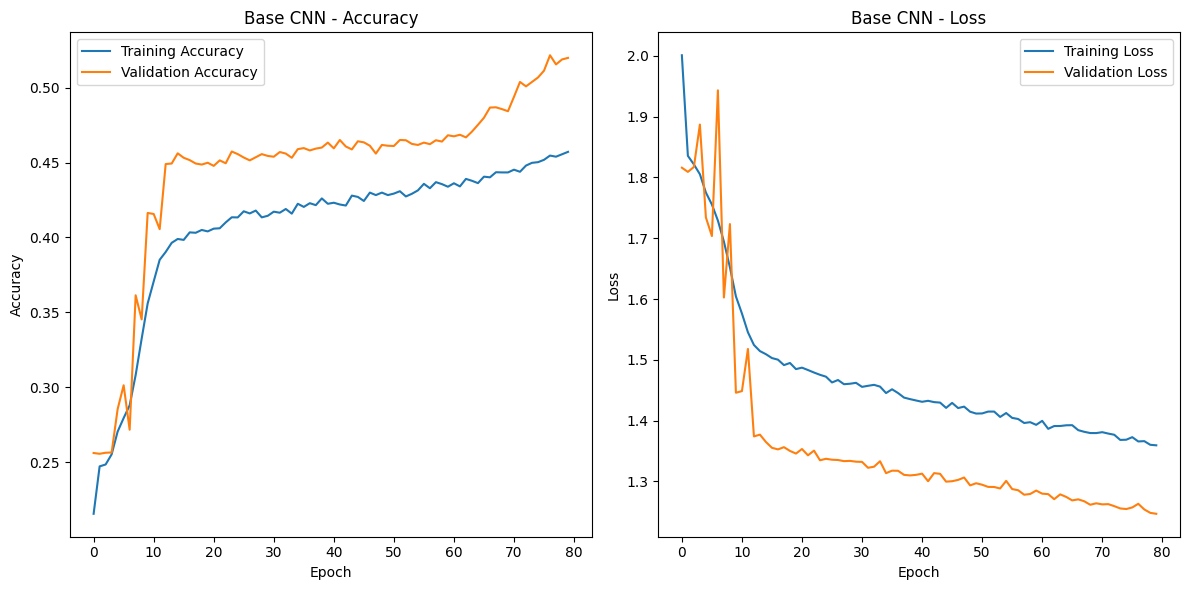

In [ ]:
# Function to plot training history
def plot_training_history(history, model_name):
    # Accuracy plots
    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_training_history(history_base_cnn, 'Base CNN')


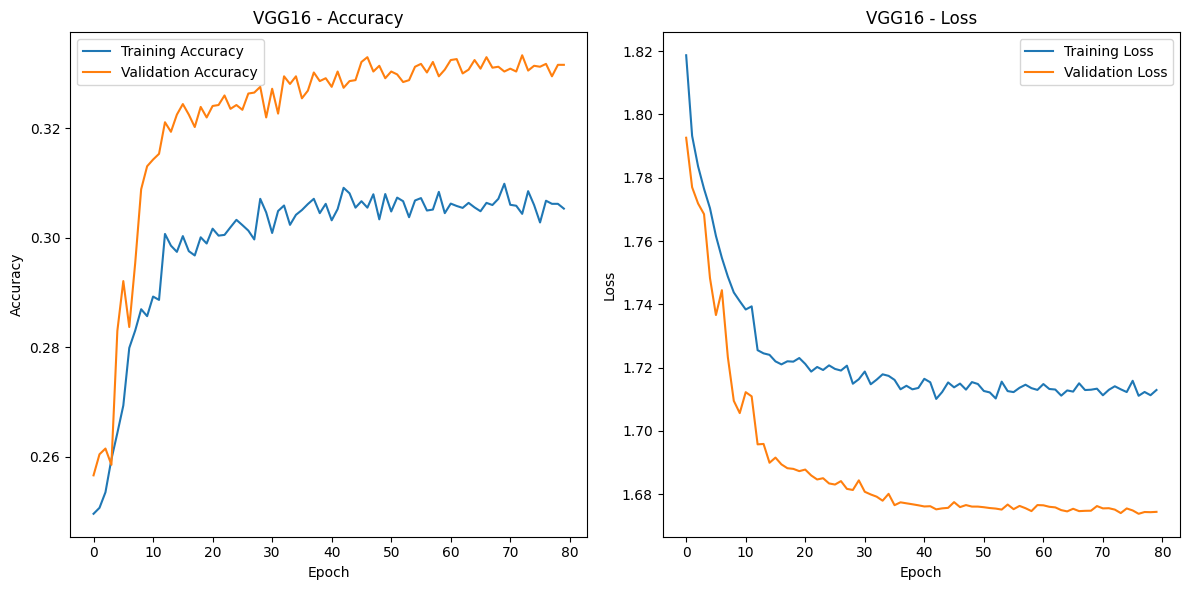

In [ ]:
plot_training_history(history_vgg16, 'VGG16')


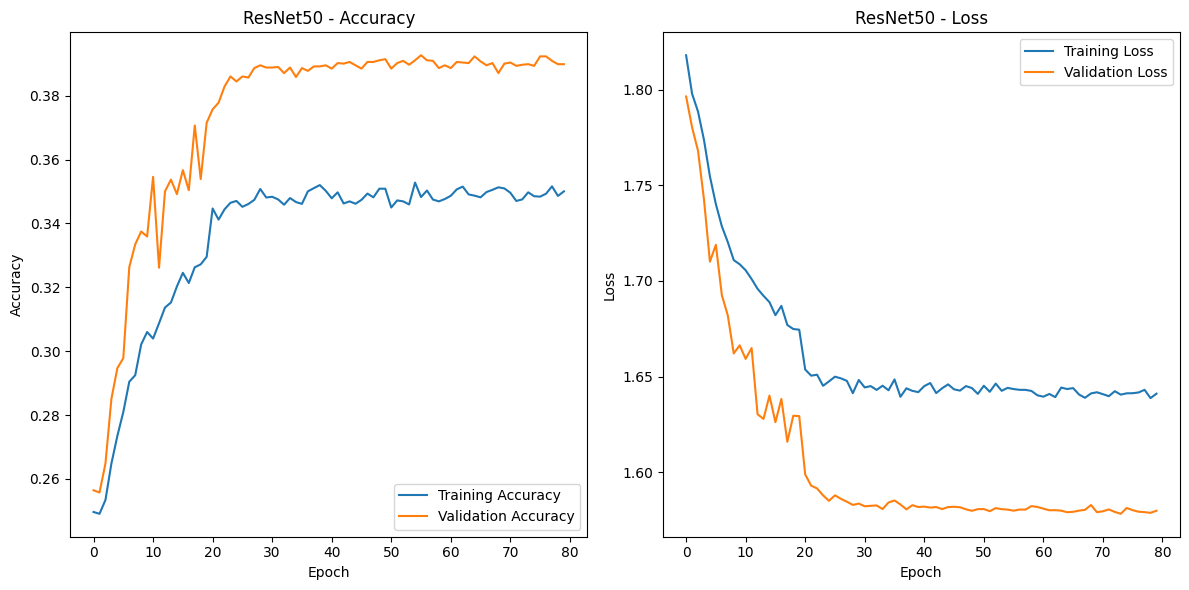

In [ ]:
plot_training_history(history_resnet50, 'ResNet50')

# Model Evaluation

Evaluate and Compare the Models

In [ ]:
# Evaluate Base CNN model with testing data
test_loss_base_cnn, test_accuracy_base_cnn = model_base_cnn.evaluate(test_datagen.flow(x_test, y_test, batch_size=batch_size))
print(f'Base CNN Test accuracy: {test_accuracy_base_cnn}')

180/180 [==============================] - 7s 37ms/step - loss: 1.2456 - accuracy: 0.5204
Base CNN Test accuracy: 0.5203761458396912


In [ ]:
# Evaluate VGG16 model with testing data
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_datagen.flow(x_test, y_test, batch_size=batch_size))
print(f'VGG16 Test accuracy: {test_accuracy_vgg16}')

180/180 [==============================] - 10s 57ms/step - loss: 1.6744 - accuracy: 0.3312
VGG16 Test accuracy: 0.33124345541000366


In [ ]:
# Evaluate ResNet50 model with testing data
test_loss_resnet50, test_accuracy_resnet50 = model_resnet50.evaluate(test_datagen.flow(x_test, y_test, batch_size=batch_size))
print(f'ResNet50 Test accuracy: {test_accuracy_resnet50}')

180/180 [==============================] - 13s 71ms/step - loss: 1.5798 - accuracy: 0.3899
ResNet50 Test accuracy: 0.38993382453918457


Plot Testing Accuracies of the Models

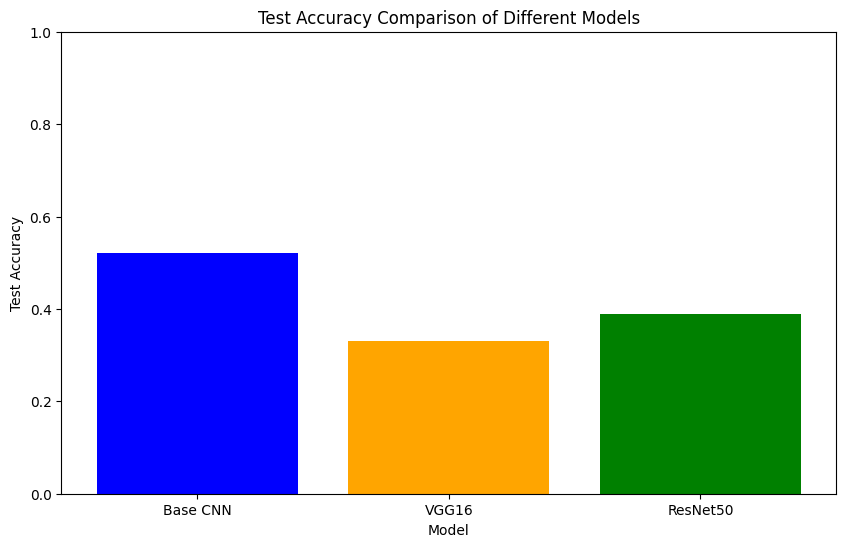

In [ ]:

# Test accuracies
models = ['Base CNN', 'VGG16', 'ResNet50']
accuracies = [test_accuracy_base_cnn, test_accuracy_vgg16, test_accuracy_resnet50]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()


# Test with our own image

Don't rebuild the models, make sure the .keras models are located within  EmotionRecognition/models


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.

In [1]:
# Import libraries
from google.colab import drive
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#Load models
cnn_path = '/content/drive/MyDrive/EmotionRecognition/models/CNNmodel.keras'
cnn_model = tf.keras.models.load_model(cnn_path)
vgg_path = '/content/drive/MyDrive/EmotionRecognition/models/VGGmodel.keras'
vgg_model = tf.keras.models.load_model(vgg_path)
res_path = '/content/drive/MyDrive/EmotionRecognition/models/RESmodel.keras'
res_model = tf.keras.models.load_model(res_path)

In [3]:
# Load and Preprocess the Image
def load_and_preprocess_image(image_path, target_size=(48, 48)):
    # Load image and convert to grayscale
    img = image.load_img(image_path, color_mode='grayscale')
    # Resize image to target size (48 x 48 by default)
    img = img.resize(target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0

    return img_array

# Load and preprocess the image
image_path = '/content/drive/MyDrive/EmotionRecognition/images/happy.jpg'  # Replace with your image name

processed_image = load_and_preprocess_image(image_path)

# Make predictions
pred_base_cnn = cnn_model.predict(processed_image)
pred_vgg16 = vgg_model.predict(processed_image)
pred_resnet50 = res_model.predict(processed_image)

# Get the class with the highest probability
pred_class_base_cnn = np.argmax(pred_base_cnn, axis=1)
pred_class_vgg16 = np.argmax(pred_vgg16, axis=1)
pred_class_resnet50 = np.argmax(pred_resnet50, axis=1)

print(f'Base CNN Prediction: Class {pred_class_base_cnn}')
print(f'VGG16 Prediction: Class {pred_class_vgg16}')
print(f'ResNet50 Prediction: Class {pred_class_resnet50}')


1/1 [==============================] - 1s 928ms/step
Base CNN Prediction: Class [2]
VGG16 Prediction: Class [3]
ResNet50 Prediction: Class [3]


Alternate print method

In [37]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
image_path = '/content/drive/MyDrive/EmotionRecognition/images/happy.jpg'  # Replace with your image name
processed_image = load_and_preprocess_image(image_path)

def print_predictions(pred, model_name):
    print(f"\n{model_name} Predictions:")
    for i in range(pred.shape[1]):
        print(f"{emotion_dict[i]}: {pred[0][i]*100:.2f}%")
    pred_class = np.argmax(pred, axis=1)
    print(f"Predicted class: {emotion_dict[pred_class[0]]} with probability {pred[0][pred_class[0]]*100:.2f}%")

# Make predictions and print them
pred_base_cnn = cnn_model.predict(processed_image)
pred_vgg16 = vgg_model.predict(processed_image)
pred_resnet50 = res_model.predict(processed_image)

print_predictions(pred_base_cnn, "Base CNN")
print_predictions(pred_vgg16, "VGG16")
print_predictions(pred_resnet50, "ResNet50")


1/1 [==============================] - 0s 42ms/step

Base CNN Predictions:
Angry: 19.57%
Disgust: 2.22%
Fear: 21.59%
Happy: 7.01%
Sad: 20.35%
Surprise: 9.40%
Neutral: 19.87%
Predicted class: Fear with probability 21.59%

VGG16 Predictions:
Angry: 15.88%
Disgust: 1.95%
Fear: 13.94%
Happy: 31.36%
Sad: 16.19%
Surprise: 5.87%
Neutral: 14.80%
Predicted class: Happy with probability 31.36%

ResNet50 Predictions:
Angry: 9.99%
Disgust: 1.16%
Fear: 9.27%
Happy: 45.87%
Sad: 13.19%
Surprise: 2.53%
Neutral: 18.00%
Predicted class: Happy with probability 45.87%


# Experiments with live webcam

In [6]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [7]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [15]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [9]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [42]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

model = cnn_model

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialize bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # get face bounding box for overlay
    for (x, y, w, h) in faces:
        cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = cv2.resize(roi_gray, (48, 48))
        cropped_img = np.expand_dims(cropped_img, -1)
        cropped_img = np.expand_dims(cropped_img, 0)

        # Normalize the image
        cropped_img = cropped_img / 255.0

        prediction = model.predict(cropped_img, verbose=0)
        predicted_emotion = emotion_dict[int(np.argmax(prediction))]
        confidence = np.max(prediction)

        # Print prediction details
        cv2.putText(bbox_array, f"{predicted_emotion} ({confidence:.2f})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

Dispaly Image and view the result

In [ ]:
# Load image for displaying
img = plt.imread(image_path)

# Plot the image
plt.imshow(img)
plt.title(f'Predictions:\nBase CNN: Class {pred_class_base_cnn}\nVGG16: Class {pred_class_vgg16}\nResNet50: Class {pred_class_resnet50}')
plt.axis('off')
plt.show()
